In [ ]:
# pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation , LSTM , Dropout , AveragePooling3D
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from lazypredict.Supervised import LazyClassifier

In [ ]:
df = pd.read_csv('data.csv')
X = df.iloc[:,1:-1]
X.head(10)
print("General info about colums,rows etc.")
df.info()
print("\nTarget variables value counts\n",df["y"].value_counts())

General info about colums,rows etc.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 180 entries, column_a to y
dtypes: int64(179), object(1)
memory usage: 15.8+ MB

Target variables value counts
 4    2300
1    2300
5    2300
2    2300
3    2300
Name: y, dtype: int64


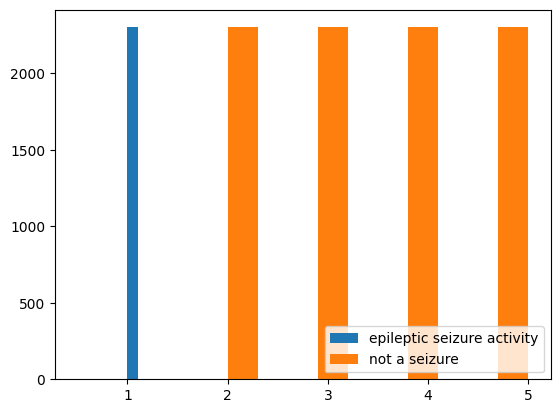

<bound method IndexOpsMixin.value_counts of 0        X21.V1.791
1        X15.V1.924
2           X8.V1.1
3         X16.V1.60
4         X20.V1.54
            ...    
11495    X22.V1.114
11496    X19.V1.354
11497      X8.V1.28
11498    X10.V1.932
11499    X16.V1.210
Name: column_a, Length: 11500, dtype: object>

In [ ]:
def hist(df,plt):
  plt.hist(df[df["y"]==1]["y"],label="epileptic seizure activity")
  plt.hist(df[df["y"]!=1]["y"],label="not a seizure")
  plt.legend(loc='lower right')
  plt.show()

hist(df,plt)

y = df.iloc[:,0]
df["column_a"].value_counts

In [ ]:
#This method drop the unnecessary column (Unnamed: 0) and transform the target variable
def prepareData(df):
  df["y"]=[1 if df["y"][i]==1 else 0 for i in range(len(df["y"]))]
  target=df["y"]
  df_copy=df.drop(["column_a","y"],axis=1)
  return df_copy,target

df_time_freq,target_time_freq=prepareData(df)

In [ ]:
# !pip install hurst #installing hurst module to get hurst values
import pywt #importing pywt for getting wavelet transform features
from hurst import compute_Hc

In [ ]:
def getHurst(df_copy):
  df_copy["hurst_ex"]=[compute_Hc(df_copy.iloc[i], kind="change", simplified=True)[0] for i in range(len(df_copy))]
  df_copy["hurst_c"]=[compute_Hc(df_copy.iloc[i], kind="change", simplified=True)[1] for i in range(len(df_copy))]
  return df_copy


def getStatsForHurst(df_copy):
  plt.scatter(df_copy["hurst_ex"],target_time_freq)
  print("mean value of hurst exponent for class 1:",np.mean(df_copy.iloc[target_time_freq[target_time_freq==1].index]["hurst_ex"]))
  print("mean value of hurst exponent for class 0:",np.mean(df_copy.iloc[target_time_freq[target_time_freq==0].index]["hurst_ex"]))
  print("mean value of hurst constant for class 1:",np.mean(df_copy.iloc[target_time_freq[target_time_freq==1].index]["hurst_c"]))
  print("mean value of hurst constant for class 0:",np.mean(df_copy.iloc[target_time_freq[target_time_freq==0].index]["hurst_c"]))
  print("median value of hurst exponent for class 1:",np.median(df_copy.iloc[target_time_freq[target_time_freq==1].index]["hurst_ex"]))
  print("median value of hurst exponent for class 0:",np.median(df_copy.iloc[target_time_freq[target_time_freq==0].index]["hurst_ex"]))
  print("median value of hurst constant for class 1:",np.median(df_copy.iloc[target_time_freq[target_time_freq==1].index]["hurst_c"]))
  print("median value of hurst constant for class 0:",np.median(df_copy.iloc[target_time_freq[target_time_freq==0].index]["hurst_c"]))

In [ ]:
#These methods create a new dataset with wavelet transform
#In getWaveletFeatures method, i get a group of wavelet coeffient and hurst exponent and the constant for all instance 
#give these values to statisticsForWavelet function to get coeffients quartiles,mean,median,standart deviation,variance,root mean square and some other values.
#Lastly createDfWavelet method give all these values and return a new dataframe
def getWaveletFeatures(data,target):
    list_features = []
    for signal in range(len(data)):
        list_coeff = pywt.wavedec(data.iloc[signal], "db4")
        features = []
        features.append(data.iloc[signal]["hurst_ex"])
        features.append(data.iloc[signal]["hurst_c"])
        for coeff in list_coeff:
            features += statisticsForWavelet(coeff)
        list_features.append(features)
    return createDfWavelet(list_features,target)
#This method taken from [9]
def statisticsForWavelet(coefs):
    n5 = np.nanpercentile(coefs, 5)
    n25 = np.nanpercentile(coefs, 25)
    n75 = np.nanpercentile(coefs, 75)
    n95 = np.nanpercentile(coefs, 95)
    median = np.nanpercentile(coefs, 50)
    mean = np.nanmean(coefs)
    std = np.nanstd(coefs)
    var = np.nanvar(coefs)
    rms = np.nanmean(np.sqrt(coefs**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def createDfWavelet(data,target):
  for i in range(len(data)):
    data[i].append(target[i])
  return pd.DataFrame(data) 

mean value of hurst exponent for class 1: 0.17426759520249877
mean value of hurst exponent for class 0: 0.5044276844723696
mean value of hurst constant for class 1: 22.53775958904113
mean value of hurst constant for class 0: 9.765791813075161
median value of hurst exponent for class 1: 0.16788038442091016
median value of hurst exponent for class 0: 0.5082046350724865
median value of hurst constant for class 1: 10.294529749768916
median value of hurst constant for class 0: 5.2513747999821


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.55,2.60,-305.18,-151.22,723.45,776.92,-3.30,185.21,421.06,177288.37,...,-14.96,-5.59,5.82,13.35,0.07,-0.21,9.14,83.47,7.26,0
1,-0.25,75.70,-1242.99,-488.61,1410.56,1774.82,603.49,509.29,1217.25,1481697.50,...,-24.90,-6.32,4.88,33.56,-0.51,-0.68,30.32,919.14,14.45,1
2,0.74,3.62,-309.10,-210.09,-117.13,-3.58,-153.47,-160.91,93.14,8675.68,...,-7.36,-3.53,3.43,7.00,-0.30,-0.25,4.96,24.59,3.87,0
3,0.77,12.23,-392.67,-384.16,-274.17,-168.57,-295.87,-294.45,96.60,9331.59,...,-5.07,-2.26,2.38,5.38,0.34,0.04,5.22,27.23,3.16,0
4,0.65,2.54,-276.59,-255.28,5.79,87.80,-79.86,-100.02,137.23,18831.83,...,-9.83,-3.27,3.68,9.59,-0.13,0.18,7.10,50.43,4.90,0


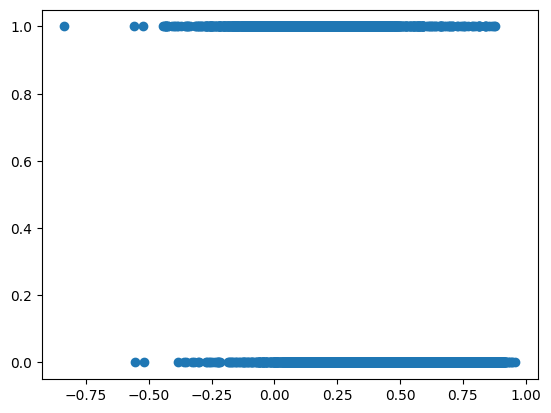

In [ ]:
df_copy=getHurst(df_time_freq)
getStatsForHurst(df_time_freq)

df_time_freq=getWaveletFeatures(df_time_freq,target_time_freq)
df_time_freq.head()#our new dataset is ready

20    1
21    0
22    1
23    1
24    1
25    0
26    0
27    1
28    0
29    0
Name: 47, dtype: int64


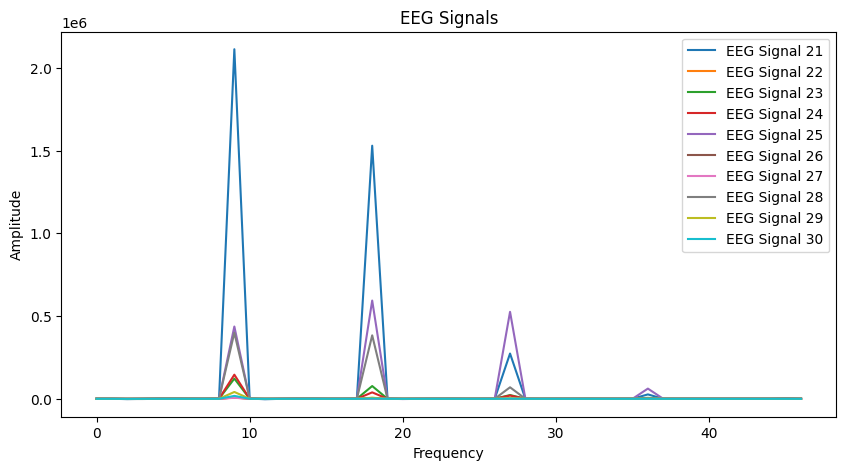

In [ ]:
print(df_time_freq.iloc[20:30, -1])
fig, ax = plt.subplots(figsize=(10, 5))

for i in range(20, 30):
    ax.plot(df_time_freq.iloc[i, :-1], label='EEG Signal {}'.format(i+1))

ax.legend(loc='upper right')
ax.set_xlabel('Frequency')
ax.set_ylabel('Amplitude')
ax.set_title('EEG Signals')
plt.show()

In [ ]:
from sklearn.utils import shuffle
def createBalancedDataset(data,random_state):
  #shuffling for random sampling
  X = shuffle(data,random_state=random_state)
  #getting first 6500 value
  return X.sort_values(by=47, ascending=False).iloc[:6500].index

0    4200
1    2300
Name: 47, dtype: int64

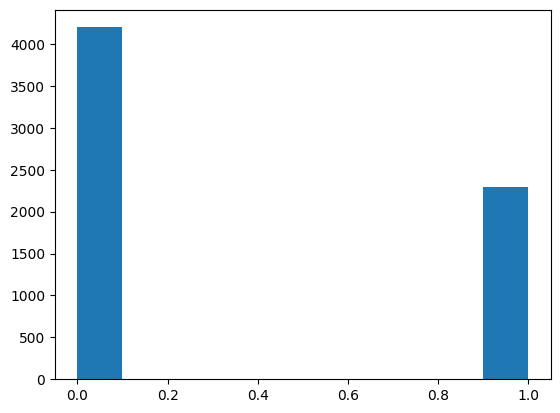

In [ ]:
v=createBalancedDataset(df_time_freq,42)
plt.hist((df_time_freq.iloc[v])[47])
(df_time_freq.iloc[v][47]).value_counts() #more balanced dataset

In [ ]:
#normalizing dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_time_freq.drop([47],axis=1))
n_df_fea=pd.DataFrame(scaler.transform(df_time_freq.drop([47],axis=1)))

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
X_trainr, X_testr, y_trainr, y_testr = train_test_split(n_df_fea.iloc[v], target_time_freq.iloc[v], test_size=0.30, random_state=42)

In [ ]:
X_train_random_sampling, X_test_random_sampling, y_train_random_sampling, y_test_random_sampling = train_test_split(X_trainr, y_trainr, test_size=0.30, random_state=42)
print(X_train_random_sampling.shape, X_test_random_sampling.shape, y_train_random_sampling.shape, y_test_random_sampling.shape)

(3185, 47) (1365, 47) (3185,) (1365,)


In [ ]:
# This is done to just test the accuracy in case of SVM classifier
from sklearn import svm
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

#I will explain this model in model part in the notebook
clf = svm.SVC(kernel="linear")
clf.fit(X_trainr, y_trainr)
#cross validation is 10
y_pred = cross_val_predict(clf,X_testr,y_testr,cv=10)
print("All features are inclueded\n",classification_report(y_testr, y_pred))

All features are inclueded
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      1373
           1       0.98      0.93      0.95       772

    accuracy                           0.97      2145
   macro avg       0.97      0.96      0.96      2145
weighted avg       0.97      0.97      0.97      2145



Selecting most important 20 features with Random Forest

In [ ]:
#Firstly I used grid Search for getting best hyperparameter for random-forest
np.random.seed(42)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'max_depth': [2,5],
    'min_samples_split':[2,5,10],
    'n_estimators': [100,150],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X_trainr, y_trainr)
print (CV_rfc.best_params_)

{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 150}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42,max_depth=5,max_features='sqrt',min_samples_split=2,n_estimators=150)
clf.fit(X_trainr, y_trainr)
#I also get the importance rates and sort in a desending order and create a dataframe
zipped=pd.DataFrame(zip(X_trainr.columns,clf.feature_importances_),columns=["column","importance"]).sort_values(by="importance", ascending=False)
y_pred2 = cross_val_predict(clf,X_testr,y_testr,cv=10)
print("All featuares are included\n",classification_report(y_testr, y_pred2))

All featuares are included
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1373
           1       0.96      0.96      0.96       772

    accuracy                           0.97      2145
   macro avg       0.97      0.97      0.97      2145
weighted avg       0.97      0.97      0.97      2145



In [ ]:
zipped.head(20) #The most important 20 values according to random forest

,column,importance
18,18,0.12
17,17,0.10
8,8,0.09
9,9,0.08
19,19,0.08
36,36,0.08
35,35,0.07
14,14,0.05
11,11,0.05
26,26,0.04


Epoch 1/50
61/61 - 6s - loss: 0.6471 - accuracy: 0.6468 - val_loss: 0.6320 - val_accuracy: 0.6401 - 6s/epoch - 101ms/step
Epoch 2/50
61/61 - 3s - loss: 0.5844 - accuracy: 0.7084 - val_loss: 0.5318 - val_accuracy: 0.7441 - 3s/epoch - 54ms/step
Epoch 3/50
61/61 - 2s - loss: 0.5207 - accuracy: 0.7862 - val_loss: 0.5659 - val_accuracy: 0.7026 - 2s/epoch - 37ms/step
Epoch 4/50
61/61 - 2s - loss: 0.4290 - accuracy: 0.8292 - val_loss: 0.5664 - val_accuracy: 0.6797 - 2s/epoch - 37ms/step
Epoch 5/50
61/61 - 2s - loss: 0.4007 - accuracy: 0.8429 - val_loss: 0.4042 - val_accuracy: 0.8107 - 2s/epoch - 37ms/step
Epoch 6/50
61/61 - 2s - loss: 0.3489 - accuracy: 0.8650 - val_loss: 0.3586 - val_accuracy: 0.8364 - 2s/epoch - 37ms/step
Epoch 7/50
61/61 - 3s - loss: 0.3321 - accuracy: 0.8691 - val_loss: 0.3377 - val_accuracy: 0.8503 - 3s/epoch - 54ms/step
Epoch 8/50
61/61 - 2s - loss: 0.3109 - accuracy: 0.8792 - val_loss: 0.4234 - val_accuracy: 0.8256 - 2s/epoch - 37ms/step
Epoch 9/50
61/61 - 2s - loss: 0

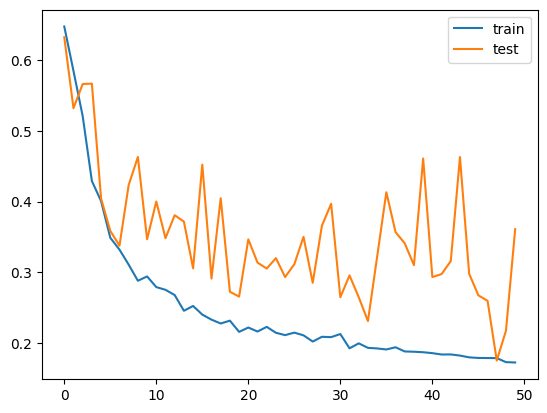

In [ ]:
# Tried LSTM implementation
#LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
# When i designed the network, Basically i used heuristic approach
X_trainrr=np.array(X_trainr).reshape(X_trainr.shape[0],X_trainr.shape[1],1)
X_testrr=np.array(X_testr).reshape(X_testr.shape[0],X_testr.shape[1],1)
model = Sequential()
model.add(LSTM(50, input_shape=(X_trainrr.shape[1], X_trainrr.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
# fit network
history = model.fit(X_trainrr, y_trainr, epochs=50, batch_size=72, validation_data=(X_testrr, y_testr), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
###################################################################################### Using Lazy predict classfier ########################################################################################333

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_trainr, X_testr, y_trainr, y_testr)
models

100%|██████████| 29/29 [00:31<00:00,  1.08s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.99,0.98,0.98,0.99,2.39
LGBMClassifier,0.99,0.98,0.98,0.99,1.85
ExtraTreesClassifier,0.98,0.98,0.98,0.98,1.29
SVC,0.98,0.98,0.98,0.98,0.49
RandomForestClassifier,0.98,0.98,0.98,0.98,3.73
SGDClassifier,0.98,0.97,0.97,0.98,0.10
BaggingClassifier,0.98,0.97,0.97,0.98,1.87
AdaBoostClassifier,0.98,0.97,0.97,0.98,1.83
KNeighborsClassifier,0.98,0.97,0.97,0.98,0.81


In [ ]:
clf_random_sampling = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models_random_sampling,predictions_random_sampling = clf.fit(X_train_random_sampling, X_test_random_sampling, y_train_random_sampling, y_test_random_sampling)
models_random_sampling

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:11<00:00,  2.51it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.98,0.98,0.98,0.98,0.57
ExtraTreesClassifier,0.98,0.97,0.97,0.98,0.35
XGBClassifier,0.98,0.97,0.97,0.98,1.32
RandomForestClassifier,0.97,0.97,0.97,0.97,1.52
AdaBoostClassifier,0.97,0.97,0.97,0.97,2.33
SGDClassifier,0.97,0.97,0.97,0.97,0.07
LinearSVC,0.97,0.97,0.97,0.97,0.18
LogisticRegression,0.97,0.96,0.96,0.97,0.07
BaggingClassifier,0.97,0.96,0.96,0.97,1.33


In [ ]:
########################################################################### Trying out after doing feature extraction ################################################################

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42,max_depth=5,max_features='sqrt',min_samples_split=2,n_estimators=150)
clf.fit(X_trainr, y_trainr)
#I also get the importance rates and sort in a desending order and create a dataframe
zipped=pd.DataFrame(zip(X_trainr.columns,clf.feature_importances_),columns=["column","importance"]).sort_values(by="importance", ascending=False)

In [ ]:
X_trainr_FE = X_trainr[zipped.iloc[:,:20].index]
y_trainr_FE = y_trainr
X_testr_FE = X_testr[zipped.iloc[:,:20].index]
y_testr_FE = y_testr
##############################################################################
X_train_random_sampling_FE = X_train_random_sampling[zipped.iloc[:,:20].index]
y_train_random_sampling_FE = y_train_random_sampling
X_test_random_sampling_FE = X_test_random_sampling[zipped.iloc[:,:20].index]
y_test_random_sampling_FE = y_test_random_sampling

In [ ]:
clf_FE = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models_FE,predictions_FE = clf_FE.fit(X_trainr_FE, X_testr_FE, y_trainr_FE, y_testr_FE)
models_FE

100%|██████████| 29/29 [00:17<00:00,  1.62it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.99,0.98,0.98,0.99,0.64
XGBClassifier,0.98,0.98,0.98,0.98,2.07
ExtraTreesClassifier,0.98,0.98,0.98,0.98,0.47
SVC,0.98,0.98,0.98,0.98,0.43
BaggingClassifier,0.98,0.98,0.98,0.98,1.85
RandomForestClassifier,0.98,0.97,0.97,0.98,2.98
SGDClassifier,0.98,0.97,0.97,0.98,0.10
AdaBoostClassifier,0.98,0.97,0.97,0.98,2.32
KNeighborsClassifier,0.98,0.97,0.97,0.98,0.12


In [ ]:
clf_random_sampling_FE = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models_random_sampling_FE,predictions_random_sampling_FE = clf_random_sampling_FE.fit(X_train_random_sampling_FE, X_test_random_sampling_FE, y_train_random_sampling_FE, y_test_random_sampling_FE)
models_random_sampling_FE

100%|██████████| 29/29 [00:11<00:00,  2.57it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.98,0.98,0.98,0.98,0.36
LGBMClassifier,0.98,0.98,0.98,0.98,0.56
XGBClassifier,0.98,0.97,0.97,0.98,1.64
RandomForestClassifier,0.97,0.97,0.97,0.97,1.97
AdaBoostClassifier,0.97,0.97,0.97,0.97,1.30
SGDClassifier,0.97,0.97,0.97,0.97,0.11
LinearSVC,0.97,0.97,0.97,0.97,0.18
LogisticRegression,0.97,0.96,0.96,0.97,0.07
BaggingClassifier,0.97,0.96,0.96,0.97,1.17
